# Review 3 
# Topic: Time Series Forecasting and Visualization on Global Terrorism

## Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from pmdarima.arima.utils import ndiffs
import pmdarima as pm
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm
from pmdarima import auto_arima
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM

Using TensorFlow backend.


### Loading the Dataset

In [2]:
df = pd.read_csv('terrorism.csv',encoding="ISO-8859-1", low_memory=False)
df.tail() 

,eventid,iyear,imonth,iday,approxdate,extended,resolution,country,country_txt,region,...,addnotes,scite1,scite2,scite3,dbsource,INT_LOG,INT_IDEO,INT_MISC,INT_ANY,related
181686,201712310022,2017,12,31,NaN,0,NaN,182,Somalia,11,...,NaN,"""Somalia: Al-Shabaab Militants Attack Army Che...","""Highlights: Somalia Daily Media Highlights 2 ...","""Highlights: Somalia Daily Media Highlights 1 ...",START Primary Collection,0,0,0,0,NaN
181687,201712310029,2017,12,31,NaN,0,NaN,200,Syria,10,...,NaN,"""Putin's 'victory' in Syria has turned into a ...","""Two Russian soldiers killed at Hmeymim base i...","""Two Russian servicemen killed in Syria mortar...",START Primary Collection,-9,-9,1,1,NaN
181688,201712310030,2017,12,31,NaN,0,NaN,160,Philippines,5,...,NaN,"""Maguindanao clashes trap tribe members,"" Phil...",NaN,NaN,START Primary Collection,0,0,0,0,NaN
181689,201712310031,2017,12,31,NaN,0,NaN,92,India,6,...,NaN,"""Trader escapes grenade attack in Imphal,"" Bus...",NaN,NaN,START Primary Collection,-9,-9,0,-9,NaN
181690,201712310032,2017,12,31,NaN,0,NaN,160,Philippines,5,...,NaN,"""Security tightened in Cotabato following IED ...","""Security tightened in Cotabato City,"" Manila ...",NaN,START Primary Collection,-9,-9,0,-9,NaN


In [3]:
# Now we will be seeing if there are any null values in the nkill attribute of the dataset 
df['nkill'].isnull().sum()

10313

In [4]:
# Since Above dataset indicated that for those 10,313 tuples we don't have the data hence we will fill those with 0
df.nkill = df.nkill.fillna(0)

In [5]:
# Now let's check again
df.nkill.isnull().sum()

0

### Extracting the wanted columns

In [6]:
res_df = pd.DataFrame()
res_df['kills'] = df.groupby(['iyear'])['nkill'].sum()
res_df.head()

,kills
iyear,
1970,174.0
1971,173.0
1972,566.0
1973,370.0
1974,539.0


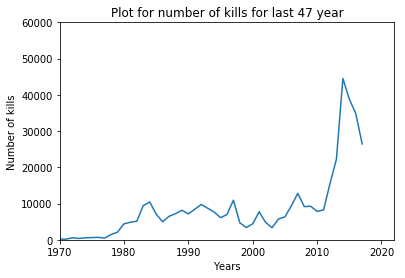

In [7]:
# Let's See the plot of it
plt.plot(res_df.kills)
plt.xlim([1970,2022])
plt.ylim([0,60000])
plt.title('Plot for number of kills for last 47 year')
plt.xlabel('Years')
plt.ylabel('Number of kills')
plt.show()

In [8]:
# Now we shall perform the Augmented Dickey Fuller Test to check whether the given series is stationary or not.
# Note: If the p-value<0.05(confidenc level) then we reject the null hypothesis and the series is stationary
def adFuller(df):
    print("Results of Augmented Dickey fuller Test")
    dftest = adfuller(df,autolag='AIC')
    return f'p value from ADFuller Test: {dftest[1]}'

In [9]:
adFuller(res_df)

Results of Augmented Dickey fuller Test


'p value from ADFuller Test: 0.6990563058690462'

In [10]:
# Since the value is more than we will the first order difference first
tempCheck = res_df[:]
tempCheck['kills_first_diff'] = tempCheck['kills'] - tempCheck['kills'].shift(1)
tempCheck.head()

C:\Users\SAHIL\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,kills,kills_first_diff
iyear,,
1970,174.0,NaN
1971,173.0,-1.0
1972,566.0,393.0
1973,370.0,-196.0
1974,539.0,169.0


In [11]:
# Again Testing on temp data for the stationary if the orrder of differencing is one
adFuller(tempCheck['kills_first_diff'].dropna())

Results of Augmented Dickey fuller Test


'p value from ADFuller Test: 6.0673452839165735e-05'

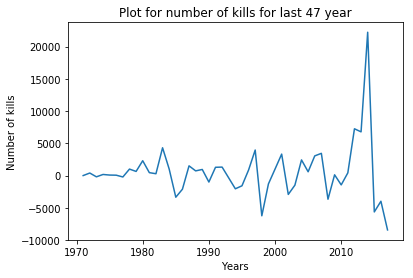

In [12]:
# Here the p value obtained is less than 0.05 thus we will be rejecting the null hypothesis. So data is stationary. Here is the plot

tempCheck['kills_first_diff'].plot()
plt.title('Plot for number of kills for last 47 year')
plt.xlabel('Years')
plt.ylabel('Number of kills')
plt.show()

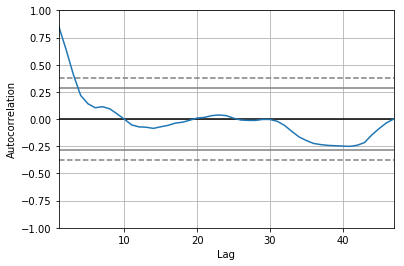

In [13]:
# Let's see the correlation plot now for the original kills
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(res_df['kills'])
plt.show()

In [14]:
# Since The the first order differencing much less than 0.05 hence we will go with that also there mulptiple other ways to check the d value for ARIMA

y = res_df.kills

# by adf test
ndiffs(y,test='adf')

1

### Now we will determining the AR Terms by PACF (p)

In [15]:
tempCheck.dropna(inplace=True)

C:\Users\SAHIL\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


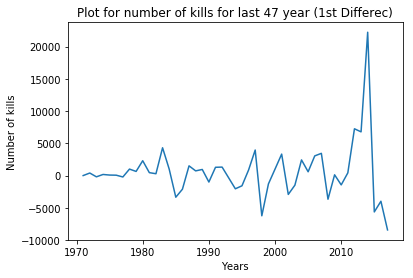

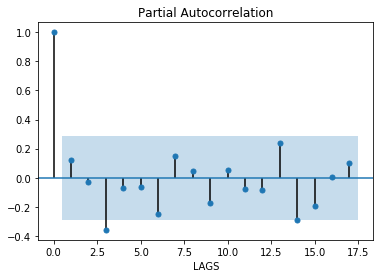

In [16]:
# Orginal First order difference plot for the kills
tempCheck['kills_first_diff'].plot()
plt.title('Plot for number of kills for last 47 year (1st Differec)')
plt.xlabel('Years')
plt.ylabel('Number of kills')

# PACF plot for First order difference plot
plot_pacf(tempCheck['kills_first_diff'])
plt.xlabel('LAGS')

plt.show()


### Since in the above plot the lag 0 is well above the significance line we will take the p value as 0

### Now we will determining the MA Terms by ACF (q)

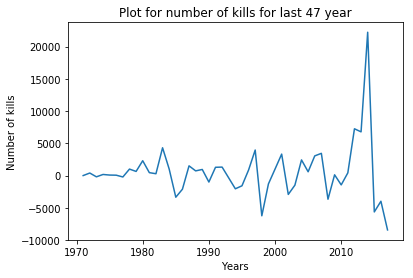

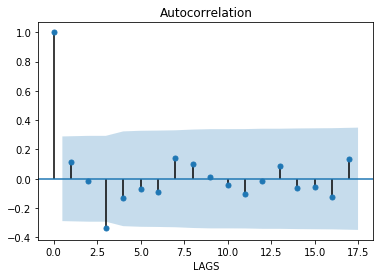

In [17]:
# Orginal First order difference plot for the kills
tempCheck['kills_first_diff'].plot()
plt.title('Plot for number of kills for last 47 year')
plt.xlabel('Years')
plt.ylabel('Number of kills')

# ACF plot for First order difference plot
plot_acf(tempCheck['kills_first_diff'])
plt.xlabel('LAGS')

plt.show()

### Since in the above ACF plot the lag 0 is well above the significance line we will take the q value as 0

### Now the p,d,q values we have got are 0,1,0. There are other methods as well tpo find it let's see those as well

In [18]:
stepwise_fit = auto_arima(res_df, trace=True, suppress_warnings=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=909.452, Time=0.19 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=905.607, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=906.914, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=907.115, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=904.398, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=909.080, Time=0.05 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.321 seconds


In [19]:
# Through auto_arima as well we can confirm our findings thus p,d,q = (0,1,0). Now lets make the model
model = ARIMA(res_df.kills,order=(0,1,0))
model_fit = model.fit(disp=0)
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.kills   No. Observations:                   46
Model:                 ARIMA(0, 1, 0)   Log Likelihood                -450.803
Method:                           css   S.D. of innovations           4363.951
Date:                Mon, 07 Jun 2021   AIC                            905.607
Time:                        22:05:17   BIC                            909.264
Sample:                             1   HQIC                           906.977
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        571.1087    643.429      0.888      0.375    -689.990    1832.207
C:\Users\SAHIL\AppData\Local\Programs\Python\Python37\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmo

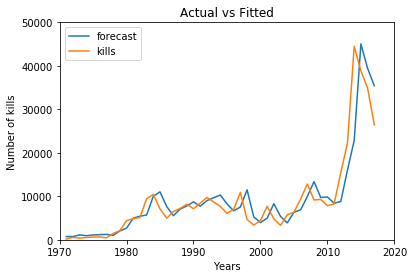

In [20]:
# Now the above model has plotted using all the values lets see the predicted/fitted values plot
model_fit.plot_predict()
plt.title('Actual vs Fitted')
plt.xlabel('Years')
plt.ylabel('Number of kills')
plt.xlim([1970,2020])
plt.ylim([0,50000])
plt.show()

#### Also note there were no seasonality in our model which is clearly observable

## We will see for Out-of-Time Cross validation 

In [21]:
# We will divide our original dataset into training and test like 75% train and 25% test
train = res_df.iloc[:35]
test = res_df.iloc[35:]

In [22]:
train.head()

,kills
iyear,
1970,174.0
1971,173.0
1972,566.0
1973,370.0
1974,539.0


C:\Users\SAHIL\AppData\Local\Programs\Python\Python37\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
C:\Users\SAHIL\AppData\Local\Programs\Python\Python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsup

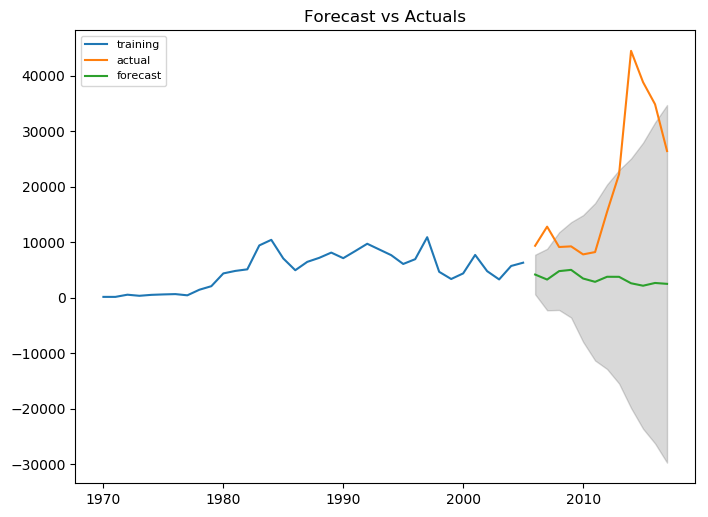

In [23]:
new_model = ARIMA(train.kills, order=(3, 2, 0))  
fitted = new_model.fit(disp=-1)  

# Forecast
fc, se, conf = fitted.forecast(12, alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test.index)
lower_series = pd.Series(conf[:, 0], index=test.index)
upper_series = pd.Series(conf[:, 1], index=test.index)

# Plot
plt.figure(figsize=(8,6), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [24]:
# Since we observe for out of time the predictions are not good so we look by fit_wise auto arima and lets take seasonality to be true this time 

smodel = pm.auto_arima(train.kills, start_p=1, start_q=1,
                         test='adf',
                         max_p=3, max_q=3, m=12,
                         start_P=0, seasonal=True,
                         d=None, D=1, trace=True,
                         error_action='ignore',  
                         suppress_warnings=True, 
                         stepwise=True)

smodel.summary()

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=407.743, Time=0.50 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=403.127, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=406.118, Time=0.19 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=405.921, Time=0.26 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=404.621, Time=0.13 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=404.638, Time=0.14 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=406.618, Time=0.16 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=404.869, Time=0.01 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=404.568, Time=0.07 sec
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=406.506, Time=0.21 sec
 ARIMA(0,1,0)(0,1,0)[12] intercept   : AIC=404.460, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,1,0)[12]          
Total fit time: 1.737 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                   35
Model:             SARIMAX(0, 1, 0)x(0, 1, 0, 12)   Log Likelihood                -200.564
Date:                            Mon, 07 Jun 2021   AIC                            403.127
Time:                                    22:05:20   BIC                            404.218
Sample:                                         0   HQIC                           403.384
                                             - 35                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      4.814e+06   1.91e+06      2.515      0.012    1.06e+06    8.57e+06
===================================================================================
Ljung-Box (L1) (Q):                   1.06   Jarque-Bera (JB):                 0.72
Prob(Q):                              0.30   Prob(JB):                         0.70
Heteroskedasticity (H):               0.65   Skew:                             0.23
Prob(H) (two-sided):                  0.58   Kurtosis:                         2.24
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

C:\Users\SAHIL\AppData\Local\Programs\Python\Python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\SAHIL\AppData\Local\Programs\Python\Python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\SAHIL\AppData\Local\Programs\Python\Python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:379: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


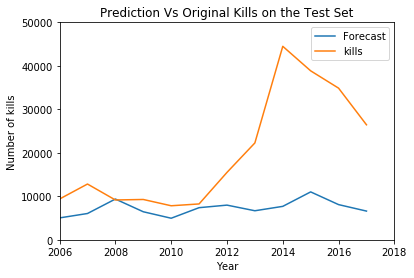

In [25]:
#Now we see the model again
tempCheck1 = res_df[:]
model = sm.tsa.SARIMAX(train.kills,order=(0,1,0),seasonal_order=(0,1,0,7))
model = model.fit()

#Visualization
start=len(train)
end=len(train)+len(test)-1
pred = model.predict(start=start,end=end,typ='levels',dynamic=True)
pred=pd.DataFrame(pred)
chk = pd.Series(range(2006,2018,1))
pred.index = chk
pred.columns.values[0]='Forecast'
df_all = pd.merge(pred,test,how='outer',left_index=True,right_index=True)
df_all.plot()
plt.xlim([2006,2018])
plt.ylim([0,50000])
plt.title('Prediction Vs Original Kills on the Test Set')
plt.xlabel('Year')
plt.ylabel('Number of kills')
plt.show()

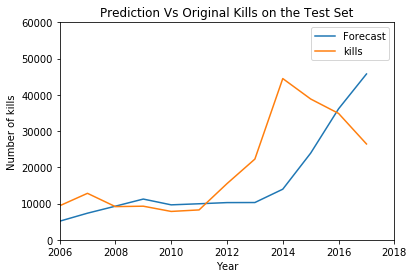

In [26]:
from numpy import array
from keras.models import Sequential
from keras.layers import LSTM

from keras.layers import Dense
 
# spliting the univariate series
def make_split(kill_sequence, n_steps):
	X, y = list(), list()
	for i in range(len(kill_sequence)):
		# To check the end of the sequence
		end_ix = i + n_steps
		# To check if we are beyond the end of the sequence
		if end_ix > len(kill_sequence)-1:
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = kill_sequence[i:end_ix], kill_sequence[end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)
 
#  input sequence will be kills  array of the training data
raw_seq = array(train.kills)
# here number of steps is 3
n_steps = 3
# split into samples
X, y = make_split(raw_seq, n_steps)
# reshape from [samples, timesteps] into [samples, timesteps, features]
n_features = 1
X = X.reshape((X.shape[0], X.shape[1], n_features))
# define model
model = Sequential()
model.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(n_steps, n_features)))
model.add(LSTM(50, activation='relu',return_sequences=True))
model.add(LSTM(50, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
# fit model
model.fit(X, y, epochs=200,verbose=0)
# demonstrate prediction
k = 32
pred = []
for i in range(12):
    x_input = array(res_df.kills[k:k+3])
    k+=1
    x_input = x_input.reshape((1, 3, n_features))
    yhat = model.predict(x_input, verbose=0)
    pred.append(yhat[0][0])


#Visualisation
new = pd.DataFrame()
pred = pd.Series(pred)
new['Forecast'] = pred
new.index = test.index
df_all = pd.merge(new,test,how='outer',left_index=True,right_index=True)
df_all.plot()
plt.xlim([2006,2018])
plt.ylim([0,60000])
plt.title('Prediction Vs Original Kills on the Test Set')
plt.xlabel('Year')
plt.ylabel('Number of kills')
plt.show()